In [23]:
from __future__ import unicode_literals, print_function, division
from io import open
import string
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
import json
import copy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import math
import dataloader as loader

In [24]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3060 Laptop GPU


In [25]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedded, hidden, n_layers, dropout):
        super().__init__()
        
        self.hidden = hidden
        self.n_layers = n_layers
        
        self.embedded = nn.Embedding(input_dim, embedded)
        self.lstm = nn.LSTM(embedded, hidden, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_tensor):
        embedded = self.dropout(self.embedded(input_tensor))
        _, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, embedded, hidden, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hidden = hidden
        self.n_layers = n_layers
        
        self.embedded = nn.Embedding(output_dim, embedded)
        self.lstm = nn.LSTM(embedded, hidden, n_layers, dropout=dropout)
        self.linear = nn.Linear(hidden, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_tensor, hidden, cell):        
        embedded = self.dropout(self.embedded(input_tensor.unsqueeze(0)))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.linear(output.squeeze(0))

        return prediction, hidden, cell
        
    def forward(self, input, hidden, cell):        
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedded(input))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.linear(output.squeeze(0))

        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, source, target, teacher_forcing_ratio = 0.5):
        batch_size = target.shape[1]
        target_len = target.shape[0]
        target_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(target_len, batch_size,
                              target_vocab_size).to(self.device)
        hidden, cell = self.encoder(source)
        input_tensor = target[0,:]
        
        for t in range(1, target_len):
            output, hidden, cell = self.decoder(input_tensor, hidden, cell)
            teacher_force = random.random() < teacher_forcing_ratio
            input_tensor = target[t] if teacher_force else output.argmax(1)
            outputs[t] = output

        return outputs

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

def train(model, train_dataloader, optimizer, criterion, clip, interval=100):
    start = time.time()
    model.train()
    epoch_loss = 0
    
    for i,data in enumerate(train_dataloader, 1):
        input_tensor, target_tensor = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(input_tensor, target_tensor)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        target_tensor = target_tensor[1:].view(-1)
        loss = criterion(output, target_tensor)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

        if i % interval == 0:
            print('%s (%d %d%%) loss: %.4f' % (timeSince(start, i / train_dataloader.__len__()),
                                         i, i / train_dataloader.__len__()*100, epoch_loss/i))
        
    return epoch_loss / train_dataloader.__len__(), model

def evaluate(model, valid_dataloader, itos, criterion):
    
    model.eval()
    
    epoch_loss = 0
    accuracy = 0
    data_len = 0
    
    with torch.no_grad():
        for i,data in enumerate(valid_dataloader, 0):
            input_tensor, target_tensor = data[0].to(device), data[1].to(device)
            output = model(input_tensor, target_tensor, 0)

            output_dim = output.shape[-1]
            output_cat = output[1:].view(-1, output_dim)
            target_cat = target_tensor[1:].view(-1)
            loss = criterion(output_cat, target_cat)
            input_tensor = torch.einsum('ij->ji',input_tensor).cpu()
            output = torch.einsum('ij...->ji...',output[1:]).cpu()
            target_tensor = torch.einsum('ij->ji',target_tensor[1:]).cpu()

            topv, topi = output.topk(1)
            topi = topi.squeeze()

            check = lambda index: itos[index] if index!=0 and index!=1 and index!=2 else '' 
            for _, (input,pred,target) in enumerate(zip(input_tensor.tolist(),topi.tolist(),target_tensor.tolist()), 0):
                input_word = ''.join(check(index) for index in input)
                pred_word = ''.join(check(index) for index in pred)
                target_word = ''.join(check(index) for index in target)
                accuracy += compute_bleu(pred_word, target_word)
                data_len += 1
            
            if i % int(valid_dataloader.__len__()/3) == 0:
                print('='*27)
                print('input:\t', input_word)
                print('target:\t', target_word)
                print('pred:\t', pred_word)
            
            epoch_loss += loss.item()
    avg_loss = epoch_loss/valid_dataloader.__len__()
    avg_acc = accuracy/data_len
    print('BLEU-4 score:%.4f, valid loss:%.4f \n' % (avg_acc, avg_loss))
    
    return avg_loss, avg_acc

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)


In [26]:
train_dataset = loader.preprocessing('../A3_data/train.json')
test_dataset = loader.preprocessing('../A3_data/test.json')
new_test_dataset = loader.preprocessing('../A3_data/new_test.json')

train_dataset = loader.Train_Dataset(train_dataset,
                                        'input_word',
                                        'target_word',
                                        freq_threshold=0)
test_dataset = loader.Validation_Dataset(train_dataset,
                                            test_dataset,
                                            'input_word',
                                            'target_word')
new_test_dataset = loader.Validation_Dataset(train_dataset,
                                                new_test_dataset,
                                                'input_word',
                                                'target_word')

train_loader = loader.get_train_loader(train_dataset,
                                        64,
                                        num_workers=0)
test_loader = loader.get_valid_loader(test_dataset,
                                        train_dataset,
                                        4,
                                        num_workers=0)
new_test_loader = loader.get_valid_loader(new_test_dataset,
                                            train_dataset,
                                            4,
                                            num_workers=0)

input_D = train_dataset.source_vocab.__len__()
output_D = train_dataset.target_vocab.__len__()
encoder_embedded_D = 256
decoder_embedded_D = 256
lstm_hidden = 512
lstm_LAYERS = 3
encoder_drop = 0.5
decoder_drop = 0.5
epochs = 20
clip = 1

enc = Encoder(input_D, encoder_embedded_D, lstm_hidden, lstm_LAYERS, encoder_drop)
dec = Decoder(output_D, decoder_embedded_D, lstm_hidden, lstm_LAYERS, decoder_drop)
model = Seq2Seq(enc, dec, device).to(device)
        
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.source_vocab.stoi['<PAD>'])

best_valid_loss = float('inf')
best_valid_acc = 0

running_loss_list = []
running_acc_list = []

best_model_wts = copy.deepcopy(model.state_dict())

start_time = time.time()
for epoch in range(epochs):    
    print("epoch %2d: " % epoch)    

    train_loss, model = train(model, train_loader, optimizer, criterion, clip, interval=20)
    running_loss_list.append(train_loss)

    valid_loss, acc = evaluate(model, test_loader, train_dataset.source_vocab.itos, criterion)
    running_acc_list.append(acc)

    if best_valid_loss > train_loss:
        best_valid_loss = train_loss
        best_model_wts = copy.deepcopy(model.state_dict())
print(f"Finished Training for ", asMinutes(start_time-time.time()))
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'LSTM-model.pt')

epoch  0: 
0m 1s (- 0m 10s) (20 9%) loss: 2.8952
0m 2s (- 0m 8s) (40 19%) loss: 2.8202
0m 2s (- 0m 7s) (60 29%) loss: 2.7792
0m 4s (- 0m 6s) (80 39%) loss: 2.7566
0m 4s (- 0m 5s) (100 49%) loss: 2.7381
0m 5s (- 0m 4s) (120 59%) loss: 2.7248
0m 6s (- 0m 2s) (140 69%) loss: 2.7113
0m 7s (- 0m 2s) (160 79%) loss: 2.7038
0m 8s (- 0m 1s) (180 89%) loss: 2.6943
0m 9s (- 0m 0s) (200 99%) loss: 2.6889
input:	 triangulaur
target:	 triangular
pred:	 conereiiinn
input:	 oportunity
target:	 opportunity
pred:	 coneeeiiinn
input:	 repatition
target:	 repartition
pred:	 coneeeiiinn
input:	 transportibility
target:	 transportability
pred:	 conerreiiinnn
BLEU-4 score:0.0419, valid loss:2.8229 

epoch  1: 
0m 0s (- 0m 8s) (20 9%) loss: 2.5918
0m 1s (- 0m 7s) (40 19%) loss: 2.5973
0m 2s (- 0m 6s) (60 29%) loss: 2.6027
0m 3s (- 0m 5s) (80 39%) loss: 2.6023
0m 4s (- 0m 4s) (100 49%) loss: 2.5926
0m 5s (- 0m 3s) (120 59%) loss: 2.5855
0m 6s (- 0m 2s) (140 69%) loss: 2.5798
0m 7s (- 0m 1s) (160 79%) loss: 2.

In [29]:
def showPlot(points, loss=True):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points, 'b')
    if loss:
        plt.title("Average Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
    else:
        plt.title("BLEU 4 Testing Score")
        plt.xlabel("Epoch")
        plt.ylabel("Score")

======== test.json ========
input:	 decieve
target:	 deceive
pred:	 deceive
input:	 juce
target:	 juice
pred:	 juice
input:	 scadual
target:	 schedule
pred:	 schedule
input:	 ecstacy
target:	 ecstasy
pred:	 ecstasy
BLEU-4 score:0.8774, valid loss:0.2264 



====== new_test.json ======
input:	 apprciate
target:	 appreciate
pred:	 appreciate
input:	 predgudis
target:	 prejudice
pred:	 pregudiss
input:	 hurple
target:	 purple
pred:	 hurple
input:	 gourgace
target:	 gorgeous
pred:	 gourence
BLEU-4 score:0.6522, valid loss:0.9041 



<Figure size 640x480 with 0 Axes>

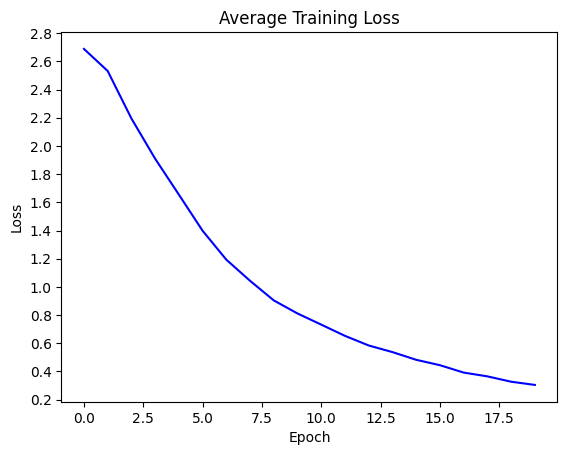

In [37]:
print("="*27)
print("="*8,"test.json","="*8)
evaluate(model, test_loader, train_dataset.source_vocab.itos, criterion)
print("\n")
print("="*27)
print("="*6,"new_test.json","="*6)
evaluate(model, new_test_loader, train_dataset.source_vocab.itos, criterion)
showPlot(running_loss_list, True)

<Figure size 640x480 with 0 Axes>

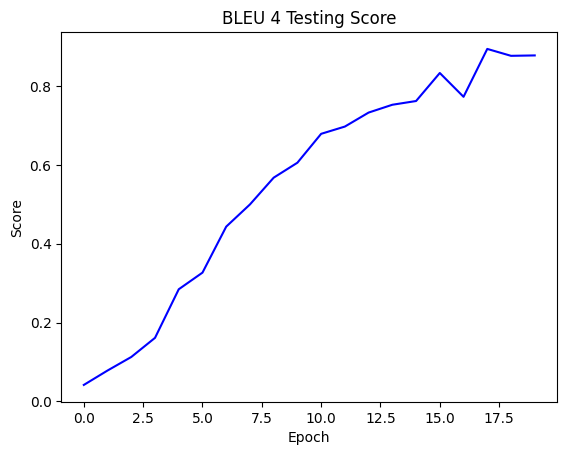

In [31]:
showPlot(running_acc_list, False)